In [ ]:
import pandas as pd
from pandas import * 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
lowess = sm.nonparametric.lowess
import os
from pandas import Series, DataFrame

In [6]:
### code to important and clean the data###
#def open_files():
#    directory = './PYTHON PROJECT/Diabetes-Data'
#    with open ('./PYTHON PROJECT/Diabetes-Data/combined_data.txt','w') as output_file:
#        for data_file in os.listdir(directory):
#            if data_file != '.DS_Store':
#                print ('reading from ' + data_file)
#                input_file_path = os.path.join(directory, data_file)            
#                with open (input_file_path) as input_file:
#                    line = input_file.readline().strip()
#                    while line:
#                        output_line = line + '\t' + str(data_file) + '\n'
#                        output_file.write(output_line)
#                        line = input_file.readline().strip()
#                    input_file.close()
#        output_file.close()

#if __name__ == "__main__":
#    print ('main')
#    open_files()

In [4]:
# read-in data
Diab_Data = pd.read_csv('./PYTHON PROJECT/Diabetes-Data/combined_data.txt', 
                   sep = '\t', header = None)
Diab_Data_Final = DataFrame(Diab_Data)
Diab_Data_Final.columns = ['date', 'time', 'code', 'value', 'id']
### data-29 and data-27 do not seem right. ###
### going to just chop out the problem by removing those ###
Diab_Data_Final = Diab_Data_Final[(Diab_Data_Final[['date', 'time', 'code', 'value']] !='data-29' ).all(axis=1)]
Diab_Data_Final = Diab_Data_Final[(Diab_Data_Final[['date', 'time', 'code', 'value']] !='data-27' ).all(axis=1)]

### More problems. Going to just chop out the non-numeric values ###
### the code below will scan the columns given for the values not equal to  ###
Diab_Data_Final = Diab_Data_Final[(Diab_Data_Final[['value']] !="0''" ).all(axis=1)]
Diab_Data_Final = Diab_Data_Final[(Diab_Data_Final[['value']] !='0Lo' ).all(axis=1)]
Diab_Data_Final = Diab_Data_Final[(Diab_Data_Final[['value']] !='0Hi' ).all(axis=1)]

### We just removed 8 rows ###
### convert 'value' column to numeric ###
Diab_Data_Final['value']=Diab_Data_Final.value.astype('float')
### there are weird values for time ###
### use the python function that converts the date for us ###
Diab_Data_Final['Date'] = pd.to_datetime(Diab_Data_Final['date'], errors = 'coerce')
Diab_Data_Final = Diab_Data_Final[(Diab_Data_Final['Date'] > '1980-01-01') & (Diab_Data_Final['Date'] < '2010-01-01')]

### For this, we are going to need a variable for 'part-of-day'  ###
string = Diab_Data_Final['time'].str.split(':', n = 1, expand = True) 
Diab_Data_Final['hour'] = pd.to_numeric(string[0])
Diab_Data_Final['minutes'] = pd.to_numeric(string[1])
Diab_Data_Final['total_minutes'] = Diab_Data_Final['hour']*60 + Diab_Data_Final['minutes']
bins = [0, ((11*60) + 59), ((16*60) + 59), ((24*60))]
labels = ['Morning', 'Afternoon', 'Evening']
Diab_Data_Final['part_of_day'] = pd.cut(Diab_Data_Final['total_minutes'], bins=bins, labels=labels, include_lowest=True)
# we need to get rid of NAs that are now present in the part_of_day variable #
Diab_Data_Final.isnull().sum(axis = 0)
Diab_Data_Final = Diab_Data_Final.dropna(axis = 0)

In [5]:
### some of the times are wrong
### use .loc function to access a group of columns (or rows)
    # after referencing these columns, sort them the values (of hour) along either axis ###
Diab_Data_Final.loc[:,('time', 'hour', 'minutes')].sort_values(by='hour', ascending=False).head()
Diab_Data_Final.shape

(29244, 10)

In [6]:
### get rid of columns we dont need ###
Diab_Data_Final.drop(['hour', 'minutes', 'total_minutes', 'Date'], axis = 1, inplace = True)
### Question 1: Print the first 5 lines and the data dimensions ###
dimensions = Diab_Data_Final.shape
print(dimensions)
Diab_Data_Final.head()

(29244, 6)


,date,time,code,value,id,part_of_day
0,04-21-1991,9:09,58,100.0,data-01,Morning
1,04-21-1991,9:09,33,9.0,data-01,Morning
2,04-21-1991,9:09,34,13.0,data-01,Morning
3,04-21-1991,17:08,62,119.0,data-01,Evening
4,04-21-1991,17:08,33,7.0,data-01,Evening


The original data included 70 patients and had 29,330 rows. Extensive data cleaning was necessary. The files for patients 27 and 29 were excluded on account of incorrect measurements. Times outside the 24 hour range were also dropped. We also discovered values recorded as "0Lo", "0Hi", and "0''" which were removed. Some of the dates recorded indicated had a  year listed as 1675. These were removed also. The final data set has 29,244 rows.

Description: Table 1: summary of the median and interquartile range (IQR: 25thpercentile, 75th percentile) of glucose level by pre-breakfast, post-breakfast, pre-lunch,post-lunch, pre-supper and post-supper.

In [7]:
### We will make a new data frame so we don't ruin anything ###
### Need to reference the columns referring to the pre/post for each meal. Those are given below ###
data_final_2 = Diab_Data_Final.loc[Diab_Data_Final['code'].isin(['58','59','60','61','62','63'])]
data_final_2 = data_final_2[['date', 'code', 'value']]

In [8]:
### First, we need to make some quantiles and group by the variable code ###
### Return values at the given quantile over requested axis, a la numpy.percentile ###
group_2 = data_final_2.groupby(['code'])
### We are defining lower quantile, median, and upper quantile ###
lower_quantile = group_2.quantile(0.25)
median = group_2.quantile(0.5)
upper_quantile = group_2.quantile(0.75)

### make a table of the quantiles of values ###
IQR_table = pd.concat([median, lower_quantile, upper_quantile], axis=1)
### now rename the table rows ###
IQR_table.rename(index = {'58':'Pre-Breakfast', '59':'Post-Breakfast', '60':'Pre-Lunch', 
                        '61':'Post-Lunch', '62':'Pre-Dinner', '63':'Post-Dinner'},
                 inplace = True)
### Rename the columns ###
IQR_table.columns = ['Median Glucose', '25th','75th']
IQR_table.title = 'Interquartile Range for Glucose Levels Before and After Meals'

### Construct the IQR column using strings ###
### We put a parenthesis, the value of the lower quantile, add a comma, add the value from the upper quantile 
### and then finally add a closing parenthesis ###
IQR_table['IQR'] = '(' + IQR_table['25th'].astype(str) + ', ' + IQR_table['75th'].astype(str) + ')'

#print(IQR_table)
### Since we just combined the two columns to make the IQR, we don't need the other two columns
### Drop the redundant columns to remove dimensions of table ###
IQR_table.drop(['25th', '75th'], axis = 1, inplace = True)
del IQR_table.index.name


IQR_table

,Median Glucose,IQR
Pre-Breakfast,161.0,"(107.75, 223.0)"
Post-Breakfast,190.5,"(87.0, 230.0)"
Pre-Lunch,134.0,"(85.0, 187.0)"
Post-Lunch,225.0,"(177.0, 303.5)"
Pre-Dinner,147.0,"(99.0, 201.0)"
Post-Dinner,183.0,"(104.0, 257.0)"


Table 1: Interquartile Range for Glucose Levels Before and After Meals. The highest median glucose levels are after someone has eaten lunch. As expected, the glucose level increases after meals.

Description: Table 2:  Summary of the codes 65-72.  Assume that if the code was recorded, then it was an occurrence of the event (i.e., ignore ‘value’ for these codes). Frequencies and proportions by approximate time of day for thefollowing three times:  1) morning = 00:01 AM to 11:59 AM; 2) afternoon = 12:00-16:59 PM; 3) evening:  17:00 PM to 24:00.  For example, if a patient had at least onerecording of a 65 between 00:01 AM and 11:59 AM, this is coded as a 1 for the morningperiod.  The denominator is 70 for each time window.  Therefore, if 12 patients had a65 in the first time window, then we would report 12 (17%) in that cell of the table.

In [74]:
### we need the codes 65-72 ###
### reference the ones we need from the data frame ###
codes_needed = Diab_Data_Final.loc[Diab_Data_Final['code'].isin(['65','66','67','68','69','70','71','72'])].index
data_final_3 = Diab_Data_Final.loc[codes_needed, :]

### now we group our data frame by this subset and grab the columns we need ###
question_3_data = data_final_3.groupby(['id', 'code', 'part_of_day']).size().reset_index(name='freq')
### make an indicator function that we can use to reference what we need ###
question_3_data['indicator'] = 1
question_3_data.drop(['freq'], axis = 1, inplace = True) 

### make a table with number of patients who had at least one recording of the 
### needed codes for each part of the day 
table_2 = pd.crosstab(question_3_data['code'], question_3_data['part_of_day'])

### rename the rows for the table ###
table_2.rename(index = {'65':'Hypoglycemic Symptoms', '66':'Typical Meal Ingestion', 
                        '67':'More-than-Usual Meal Ingestion', 
                        '68':'Less-than-Usual Meal Ingestion', 
                        '69':'Typical Exercise Activity', 
                        '70':'More-than-Usual Exercise Activity',
                        '71':'Less-than-Usual Exercise Activity', 
                        '72':'Unspecified Special Event'}, inplace = True)

table_2 = table_2.rename_axis('').rename_axis('', axis = 1)
### display the table ###
table_2 

,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,31,20,22
Typical Meal Ingestion,11,9,8
More-than-Usual Meal Ingestion,30,15,32
Less-than-Usual Meal Ingestion,9,7,6
Typical Exercise Activity,10,6,14
More-than-Usual Exercise Activity,12,10,21
Less-than-Usual Exercise Activity,9,11,16
Unspecified Special Event,24,11,13


In [78]:
### we divide each by 70 to get the proper proportions
### rounding to two decimal places
table_2_percents = (round((table_2/70)*100, 2)).astype(str) +' %'

# merge tables #
### Here is a combined table ###
table_combined = pd.concat([table_2,table_2_percents],axis=1)
table_combined['Morning'] = table_2['Morning'].map(str) + "(" + table_2_percents['Morning'].map(str) + ")"
table_combined['Afternoon'] = table_2['Afternoon'].map(str) + "(" + table_2_percents['Afternoon'].map(str) + ")"
table_combined['Evening'] = table_2['Evening'].map(str) + "(" + table_2_percents['Evening'].map(str) + ")"
table_combined = table_combined.T.drop_duplicates().T
table_combined

,Morning,Afternoon,Evening
,,,
Hypoglycemic Symptoms,31(44.29 %),20(28.57 %),22(31.43 %)
Typical Meal Ingestion,11(15.71 %),9(12.86 %),8(11.43 %)
More-than-Usual Meal Ingestion,30(42.86 %),15(21.43 %),32(45.71 %)
Less-than-Usual Meal Ingestion,9(12.86 %),7(10.0 %),6(8.57 %)
Typical Exercise Activity,10(14.29 %),6(8.57 %),14(20.0 %)
More-than-Usual Exercise Activity,12(17.14 %),10(14.29 %),21(30.0 %)
Less-than-Usual Exercise Activity,9(12.86 %),11(15.71 %),16(22.86 %)
Unspecified Special Event,24(34.29 %),11(15.71 %),13(18.57 %)


Tables 2a and 2b display the number of patients and the percentage of patients that have had at least one recording of the specified symptoms/ingestion/activity/event during morning, afternoon, and evening. Each cell is out of a total number of 70 subjects. We can see that about half of all patients had at least one recording of hypoglycemic symptoms in the morning and  more-than-ususal meal ingestion in the evening.

Description: Side-by-side boxplots of insulin doses (the values of codes 33-35) grouped by the insulin type and time window.  If a patient has more than one of each insulin type in a window on the same day, then sum the total doses for each type in thatwindow. 

In [46]:
### Reference the codes we need ###
numbers_needed = Diab_Data_Final.loc[Diab_Data_Final['code'].isin(['33', '34', '35'])].index
### subset the data ###
data_final_4 = Diab_Data_Final.loc[numbers_needed, :]

### sum the doses for patients with more than one dose of insulin of given type for each part of the day ###
question_4_data = data_final_4.groupby(['id', 'date', 'code', 'part_of_day'])[['value']].sum() 
### drop the resulting NAs that occur when we group as above ###
question_4_data = question_4_data.dropna()

### we have to reset the index now because we just dropped a bunch of NAs ###
### important to note that python DOES NOT AUTOMATICALLY DO THIS ###
question_4_data = question_4_data.reset_index()

### rename the codes for labels ###
question_4_data['type'] = question_4_data['code'].replace({'33': 'Regular', '34': 'NPH', '35': 'UltraLente'})
question_4_data.drop(['code'], axis = 1, inplace = True)

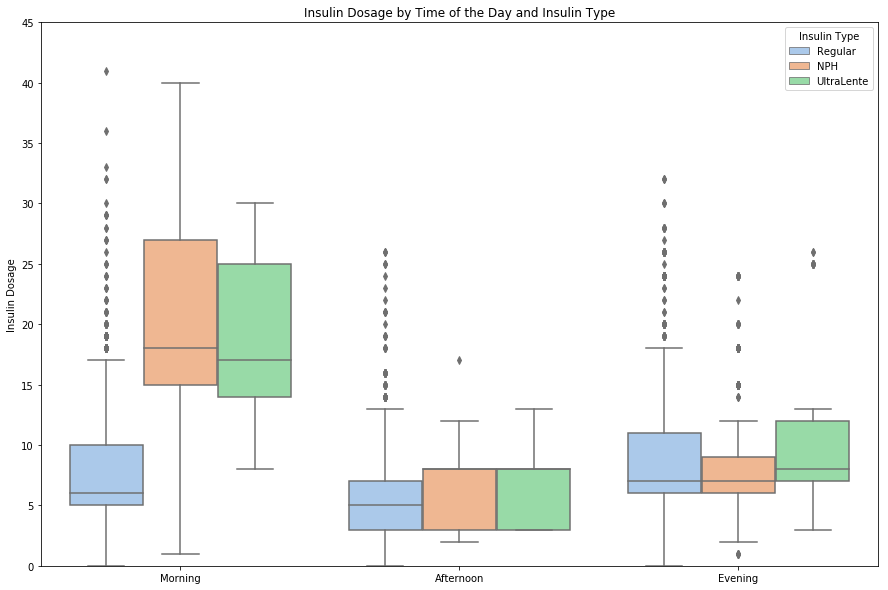

In [49]:
# boxplot by insulin type and part-of-day
plt.figure(figsize=(15,10))
plt.title('Insulin Dosage by Time of the Day and Insulin Type')
sns.boxplot(x='part_of_day', y='value', hue='type', data=question_4_data, palette='pastel')
plt.ylabel('Insulin Dosage')
plt.xlabel('')
plt.ylim(0, 45)
plt.legend(title = 'Insulin Type')
plt.show()

Above, we have a boxplot that shows the insulin dosage for subjects in the morning, afternoon, and evening and shows which type of insulin was measured as well.

Description: The time  series  of  glucose  values  across  the  entire  time  series  for  all  subjects(points).  Fit a spline through the points and add this to the plotted points.  Create1
three versions of this plot:  1) Pre and Post breakfast (two lines, different color for preand post); 2) Pre and Post lunch (two lines different colors); 3) Pre and Post supper(two lines different colors)

In [52]:
### Again, reference the codes we need ###
the_codes_needed = Diab_Data_Final.loc[Diab_Data_Final['code'].isin(['58','59','60','61','62','63'])].index
data_final_5 = Diab_Data_Final.loc[the_codes_needed, :]
data_final_5['Date'] = pd.to_datetime(data_final_5['date'], errors = 'coerce')
data_final_5['time'] = [x + ':00' for x in data_final_5['time']]
data_final_5['Time'] = pd.to_timedelta(data_final_5['time'].astype(str))

### use python function to get the right date time for the plots we need ###
data_final_5['datetime'] = pd.to_datetime(data_final_5['Date']+data_final_5['Time'])

### get rid of unneeded columns ###
data_final_5.drop(['date', 'time', 'Date', 'Time'], axis = 1, inplace = True)

### make the required pre-post variable ###
data_final_5['pre_post'] = ['Pre' if x == '58' or x == '60' or x == '62' else 'Post' for x in data_final_5['code']]

### we need to make an ordinal variable for this to work ###
data_final_5['datetime_ordinal'] = data_final_5['datetime'].apply(lambda date: date.toordinal())

In [54]:
### Subset the data into breakfast measures ###
data_final_5_breakfast = data_final_5.loc[data_final_5['code'].isin(['58', '59'])]
data_final_5_breakfast_pre = data_final_5_breakfast.loc[data_final_5_breakfast['pre_post'].isin(['Pre'])]
data_final_5_breakfast_post = data_final_5_breakfast.loc[data_final_5_breakfast['pre_post'].isin(['Post'])]

### Subset the data into lunch measures ###
data_final_5_lunch = data_final_5.loc[data_final_5['code'].isin(['60', '61'])]
data_final_5_lunch_pre = data_final_5_lunch.loc[data_final_5_lunch['pre_post'].isin(['Pre'])]
data_final_5_lunch_post = data_final_5_lunch.loc[data_final_5_lunch['pre_post'].isin(['Post'])]

### Subset the data into dinner measures ###
data_final_5_dinner = data_final_5.loc[data_final_5['code'].isin(['62', '63'])]
data_final_5_dinner_pre = data_final_5_dinner.loc[data_final_5_dinner['pre_post'].isin(['Pre'])]
data_final_5_dinner_post = data_final_5_dinner.loc[data_final_5_dinner['pre_post'].isin(['Post'])]

In [56]:
### We are going to layer the trends on underlying plots ### 
### use seaborn to create lowess plots for each meal pre/post ###
### breakfast ###
breakfast_pre_lowess = lowess(exog=data_final_5_breakfast_pre['datetime_ordinal'], endog=data_final_5_breakfast_pre['value'])
breakfast_post_lowess = lowess(exog=data_final_5_breakfast_post['datetime_ordinal'], endog=data_final_5_breakfast_post['value'])

### lunch ###
lunch_pre_lowess = lowess(exog=data_final_5_lunch_pre['datetime_ordinal'], endog=data_final_5_lunch_pre['value'])
lunch_post_lowess = lowess(exog=data_final_5_lunch_post['datetime_ordinal'], endog=data_final_5_lunch_post['value'])

### dinner ###
dinner_pre_lowess = lowess(exog=data_final_5_dinner_pre['datetime_ordinal'], endog=data_final_5_dinner_pre['value'])
dinner_post_lowess = lowess(exog=data_final_5_dinner_post['datetime_ordinal'], endog=data_final_5_dinner_post['value'])

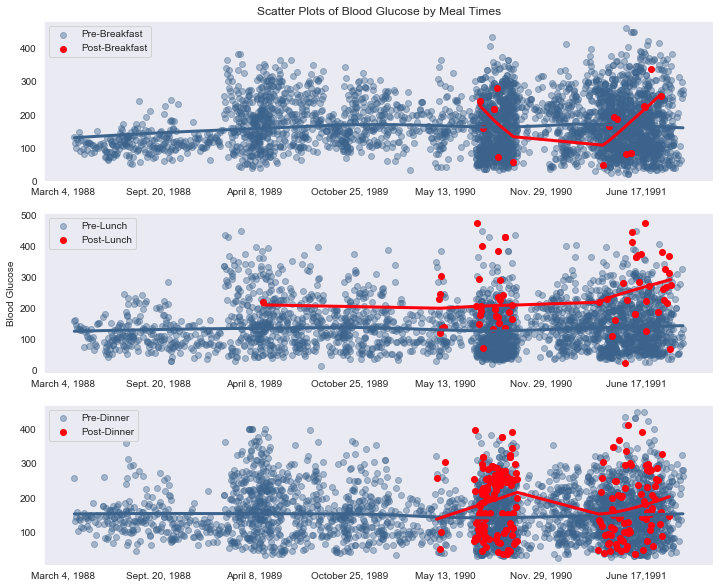

In [65]:
### plot glucose measurements over time ###
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12,10))

ax1.scatter(data_final_5_breakfast_pre.loc[:,'datetime_ordinal'], data_final_5_breakfast_pre.loc[:,'value'], color='xkcd:denim', alpha = 0.4)
ax1.scatter(data_final_5_breakfast_post.loc[:,'datetime_ordinal'], data_final_5_breakfast_post.loc[:,'value'], color='xkcd:bright red', alpha = 1)
ax1.plot(lowess1[:,0], lowess1[:,1], color='xkcd:denim', linewidth = 3)
ax1.plot(lowess2[:,0], lowess2[:,1], color='xkcd:bright red', linewidth = 3)
leg_handles = ax1.get_legend_handles_labels()[0]
ax1.legend(leg_handles, ['Pre-Breakfast', 'Post-Breakfast'])

ax2.scatter(data_final_5_lunch_pre.loc[:,'datetime_ordinal'], data_final_5_lunch_pre.loc[:,'value'], color='xkcd:denim', alpha = 0.4)
ax2.scatter(data_final_5_lunch_post.loc[:,'datetime_ordinal'], data_final_5_lunch_post.loc[:,'value'], color='xkcd:bright red', alpha = 1)
ax2.plot(lowess3[:,0], lowess3[:,1], color='xkcd:denim', linewidth = 3)
ax2.plot(lowess4[:,0], lowess4[:,1], color='xkcd:bright red', linewidth = 3)
leg_handles = ax2.get_legend_handles_labels()[0]
ax2.legend(leg_handles, ['Pre-Lunch', 'Post-Lunch'])

ax3.scatter(data_final_5_dinner_pre.loc[:,'datetime_ordinal'], data_final_5_dinner_pre.loc[:,'value'], color='xkcd:denim', alpha = 0.4)
ax3.scatter(data_final_5_dinner_post.loc[:,'datetime_ordinal'], data_final_5_dinner_post.loc[:,'value'], color='xkcd:bright red', alpha = 1)
ax3.plot(lowess5[:,0], lowess5[:,1], color='xkcd:denim', linewidth = 3)
ax3.plot(lowess6[:,0], lowess6[:,1], color='xkcd:bright red', linewidth = 3)
leg_handles = ax3.get_legend_handles_labels()[0]
ax3.legend(leg_handles, ['Pre-Dinner', 'Post-Dinner'])

ticks = [725800, 726000, 726200, 726400, 726600, 726800, 727000]
xlabs = ['March 4, 1988', 'Sept. 20, 1988', 'April 8, 1989', 'October 25, 1989', 
         'May 13, 1990', 'Nov. 29, 1990', 'June 17,1991']
ax1.set_xticks(ticks)
ax1.set_xticklabels(xlabs)
ax2.set_xticks(ticks)
ax2.set_xticklabels(xlabs)
ax3.set_xticks(ticks)
ax3.set_xticklabels(xlabs)

plt.ylabel('Blood Glucose', y=1.7)
plt.title('Scatter Plots of Blood Glucose by Meal Times', y=3.4)
plt.show()

Above is scatter plots with lowess curves fit to the points plotted for each pre and post meal time. The curves could have been smoother with different splines. It looks like blood glucose before meals doesn't vary much when compared to the more variable post-meal glucose measurements. Since the post-meal measurements are fewer (began to be collected later), this could be due to the trend of variance to decrease with more data.

Description: Density plots for each set of pre/post meal glucose readings.

.  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


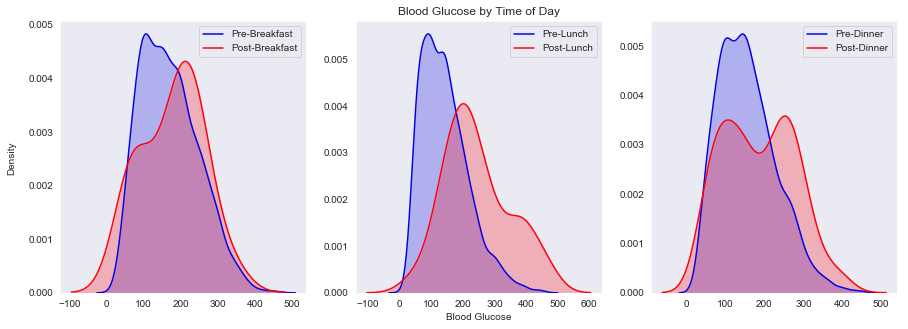

In [63]:
### we will just use the dataframes from above ###
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))


sns.kdeplot(data_final_5_breakfast_pre['value'], shade=True, color='xkcd:pure blue', ax=ax1)
sns.kdeplot(data_final_5_breakfast_post['value'], shade=True, color='xkcd:bright red', ax=ax1)
sns.set_style(style='dark')
leg_handles = ax1.get_legend_handles_labels()[0]
ax1.legend(leg_handles, ['Pre-Breakfast', 'Post-Breakfast'])

sns.kdeplot(data_final_5_lunch_pre['value'], shade=True, color='xkcd:pure blue', ax=ax2)
sns.kdeplot(data_final_5_lunch_post['value'], shade=True, color='xkcd:bright red', ax=ax2)
sns.set_style(style='dark')
leg_handles = ax2.get_legend_handles_labels()[0]
ax2.legend(leg_handles, ['Pre-Lunch', 'Post-Lunch'])

sns.kdeplot(data_final_5_dinner_pre['value'], shade=True, color='xkcd:pure blue', ax=ax3)
sns.kdeplot(data_final_5_dinner_post['value'], shade=True, color='xkcd:bright red', ax=ax3)
sns.set_style(style='dark')
leg_handles = ax3.get_legend_handles_labels()[0]
ax3.legend(leg_handles, ['Pre-Dinner', 'Post-Dinner'])

plt.xlabel('Blood Glucose', x=-0.7)
fig.text(0.08, 0.5, 'Density', ha='center', va='center', rotation=90)
plt.title('Blood Glucose by Time of Day', x=-0.7)
plt.show()